In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf

import pandas_datareader as pdr
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [3]:
stock_data = yf.download('AAPL')

[*********************100%%**********************]  1 of 1 completed


In [4]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600


In [5]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,171.759995,173.050003,170.059998,172.279999,172.279999,71106600
2024-03-25,170.570007,171.940002,169.449997,170.850006,170.850006,54288300
2024-03-26,170.000000,171.419998,169.580002,169.710007,169.710007,57388400
2024-03-27,170.410004,173.600006,170.110001,173.309998,173.309998,60273300
2024-03-28,171.750000,172.229996,170.509995,171.479996,171.479996,65672700


In [6]:
stock_data.shape

(10914, 6)

In [7]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10914.000000,10914.000000,10914.000000,10914.000000,10914.000000,1.091400e+04
mean,20.961930,21.188328,20.743293,20.975627,20.204128,3.200331e+08
std,43.529765,43.998603,43.088284,43.566541,43.151611,3.359857e+08
min,0.049665,0.049665,0.049107,0.049107,0.037952,0.000000e+00
25%,0.296875,0.302896,0.288566,0.296875,0.241885,1.147720e+08
50%,0.515625,0.526786,0.508929,0.518415,0.422789,2.079840e+08
75%,19.318572,19.530178,19.138303,19.317947,16.760282,3.999072e+08
max,198.020004,199.619995,197.000000,198.110001,197.857529,7.421641e+09


Data Cleaning

In [8]:
# predict for 30 days
num_days_pred=30

# slicing
slice = int(len(stock_data)- 356*3)
stock_data = stock_data.iloc[slice:]

# drop Open, High,Adj Close, Volume and Low from the dataset as they are not needed for prediction
stock_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)

In [9]:
stock_data.head()

,Close
Date,
2019-12-31,73.412498
2020-01-02,75.087502
2020-01-03,74.357498
2020-01-06,74.949997
2020-01-07,74.597504


In [10]:
stock_data.describe()

,Close
count,1068.000000
mean,143.088055
std,33.818278
min,56.092499
25%,125.017498
50%,147.385002
75%,171.132504
max,198.110001


In [11]:
stock_data.shape

(1068, 1)

In [12]:
# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred*1)  
    df['lag2'] = df[target].shift(num_days_pred*2)    
    df['lag3'] = df[target].shift(num_days_pred*3)    
    df['lag4'] = df[target].shift(num_days_pred*4)    
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)



    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Linear Regression

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

# Step 1: Data Collection
# Download historical stock price data for AAPL
aapl = yf.download('AAPL')

# Step 2: Data Preprocessing
# Drop any rows with missing values
aapl.dropna(inplace=True)

# Define features and target variable
X = aapl[['Open', 'High', 'Low', 'Volume']]  # Using OHLC prices and trading volume as features
y = aapl['Close']  # Predicting closing prices

# Step 3: Feature Selection
# No additional feature selection in this example

# Step 4: Model Training
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Model Evaluation
# Evaluate the model's performance
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

[*********************100%%**********************]  1 of 1 completed

Train MSE: 0.08974665878324743
Test MSE: 0.11171198752820881
Train MAE: 0.09779672454030011
Test MAE: 0.10406315006801238


Predicting future

In [18]:
future_dates = pd.date_range(start='2024-03-22', end='2024-03-26', freq='D')  # Example future dates
X_future = pd.DataFrame(index=future_dates, columns=X.columns)  # Creating an empty DataFrame
X_future['Open'] = [171.759995, 170.570007	, 170.000000, 170.410004, 171.750000]  # Example future opening prices
X_future['High'] = [173.050003, 171.940002, 171.419998, 173.600006, 172.229996]  # Example future high prices
X_future['Low'] = [170.059998, 169.449997, 169.580002, 170.110001, 170.509995]   # Example future low prices
X_future['Volume'] = [71106600, 54288300, 57388400, 60273300, 	65672700]  # Example future trading volume

# Predict using the trained model
predicted_prices = model.predict(X_future)

# Print the predicted prices for future dates
print("Predicted Prices for Future Dates:")
print(predicted_prices)


Predicted Prices for Future Dates:
[171.45750843 170.81785237 170.87409616 172.84595728 171.16317308]


in graphical manner

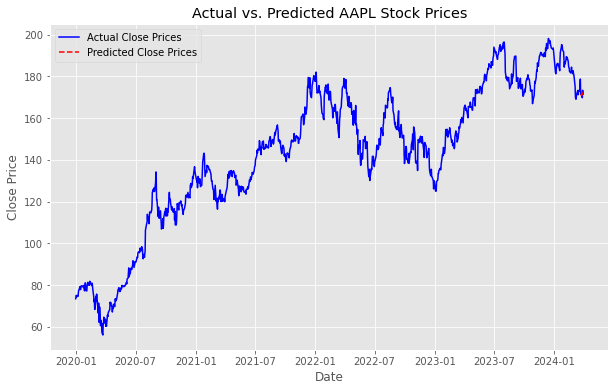

In [19]:
# Plot actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Actual Close Prices', color='blue')
plt.plot(future_dates, predicted_prices, label='Predicted Close Prices', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted AAPL Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# we can see that prediction is done very well in the graph

# XGBOOST

In [21]:
df_xgb = stock_data.copy()

In [22]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)
    
    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

In [23]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }
    
    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)
    
    # Fit the model on training data
    xgb.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-03-31 23:05:09,175] A new study created in memory with name: no-name-89aaebd5-f8cf-4e41-a348-af9e1ee7b717
[I 2024-03-31 23:05:13,627] Trial 0 finished with value: 3.4515747985382528 and parameters: {'n_estimators': 956, 'max_depth': 9, 'learning_rate': 0.06100321123062737, 'subsample': 0.8122309159278307, 'colsample_bytree': 0.6007464947228517, 'reg_alpha': 7.3845006426781445, 'reg_lambda': 6.153558224732468}. Best is trial 0 with value: 3.4515747985382528.
[I 2024-03-31 23:05:16,941] Trial 1 finished with value: 3.443784349216534 and parameters: {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.047522710022924804, 'subsample': 0.6984920260172984, 'colsample_bytree': 0.7559863036338659, 'reg_alpha': 3.3984003219782686, 'reg_lambda': 5.604962369038645}. Best is trial 1 with value: 3.443784349216534.
[I 2024-03-31 23:05:19,148] Trial 2 finished with value: 3.339963586229104 and parameters: {'n_estimators': 790, 'max_depth': 5, 'learning_rate': 0.06310803619289997, 'subsamp

Best trial:
  Value: 3.123582433954383
  Params: 
    n_estimators: 288
    max_depth: 8
    learning_rate: 0.0608893941731401
    subsample: 0.8013483513364398
    colsample_bytree: 0.9060829125714188
    reg_alpha: 3.829600984220356
    reg_lambda: 0.003415052322149892
Test RMSE: 3.123582433954383


Evaluate

In [24]:
y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb) 
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 1.7669582444745873% 


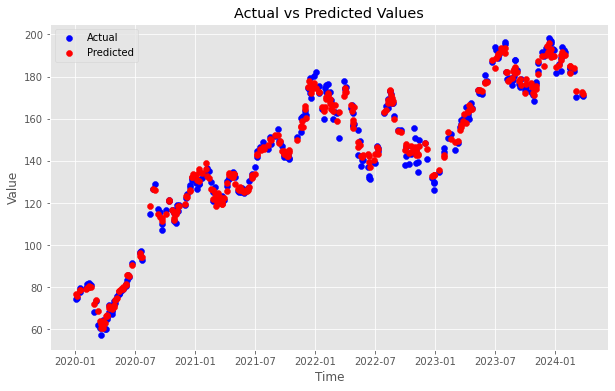

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

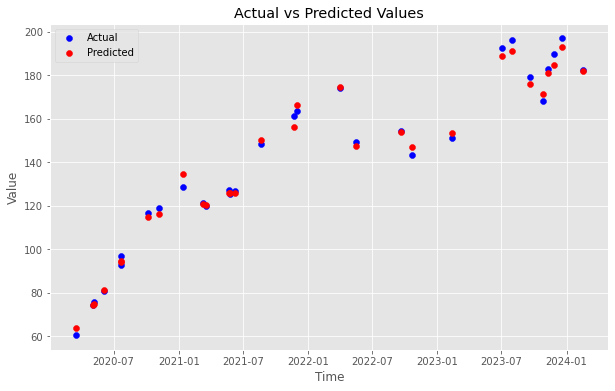

In [26]:
# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Figure size 720x432 with 0 Axes>

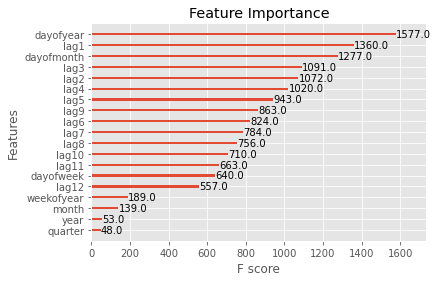

In [27]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

Predict In The Future

In [28]:
start = df_xgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

In [29]:
future = pd.date_range(start=start,end=end,freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture']= True
df_xgb['isFuture']= False
df_and_future = pd.concat([df_xgb,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

In [30]:
future_w_features['pred'] = xgb_best.predict(future_w_features.drop(columns=['Close','isFuture']))

In [32]:
# lets predict 'Close' values of next 30 days.
prediction_xgb = pd.DataFrame(future_w_features['pred'])
prediction_xgb

,pred
2024-03-28,175.486679
2024-03-29,174.683578
2024-03-30,175.631577
2024-03-31,171.284256
2024-04-01,174.442383
2024-04-02,176.426376
2024-04-03,175.704636
2024-04-04,173.771667
2024-04-05,175.384872
2024-04-06,174.670853


# Prophet algorithm

In [33]:
df_prophet = stock_data.copy()

In [34]:
split_date = df_prophet.index[int(len(df_prophet) * 0.8)]
train = df_prophet.loc[df_prophet.index <= split_date].copy()
test = df_prophet.loc[df_prophet.index > split_date].copy()

spilting data

In [35]:
split_date = df_prophet.index[int(len(df_prophet) * 0.8)]
train = df_prophet.loc[df_prophet.index <= split_date].copy()
test = df_prophet.loc[df_prophet.index > split_date].copy()

Preprocess

In [36]:
# Format data for prophet model using ds and y
train_prophet = train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

In [37]:
train_prophet 

,ds,y
0,2019-12-31,73.412498
1,2020-01-02,75.087502
2,2020-01-03,74.357498
3,2020-01-06,74.949997
4,2020-01-07,74.597504
...,...,...
850,2023-05-17,172.690002
851,2023-05-18,175.050003
852,2023-05-19,175.160004
853,2023-05-22,174.199997


Training

In [38]:
prophet = Prophet()
prophet.fit(train_prophet)

23:13:37 - cmdstanpy - INFO - Chain [1] start processing
23:13:40 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Format data for prophet model using ds and y
test_prophet = test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
test_predict = prophet.predict(test_prophet)

Evaluating

In [40]:
porphet_loss = mean_absolute_percentage_error(test['Close'],test_predict['yhat'] )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test['Close'],test_predict['yhat'] ) }% ")

ERROR PERCENT = 6.436175895278386% 


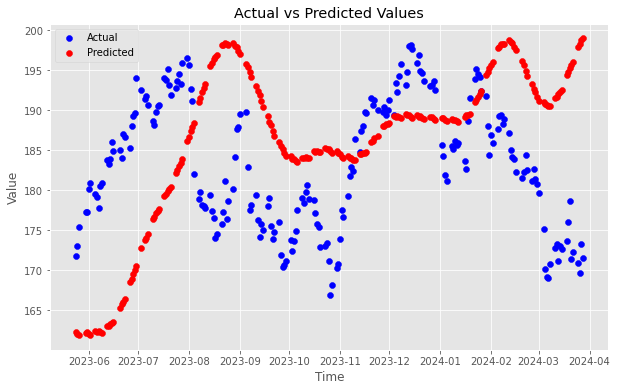

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['Close'], color='blue', label='Actual')
plt.scatter(test.index, test_predict['yhat'] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

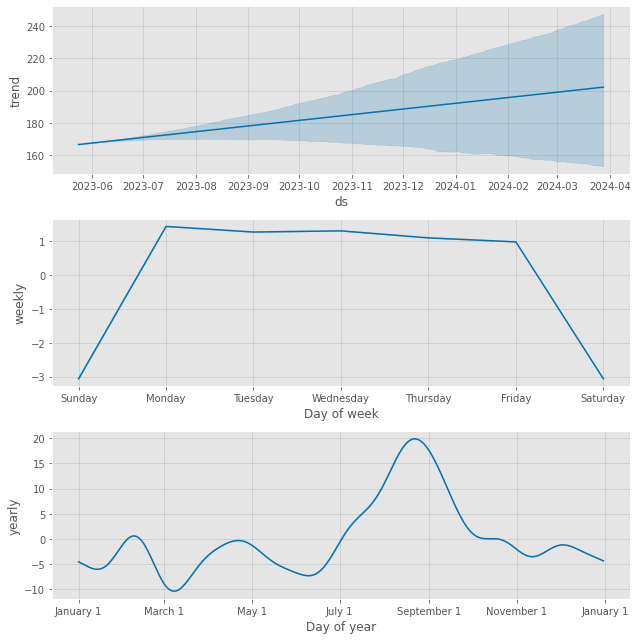

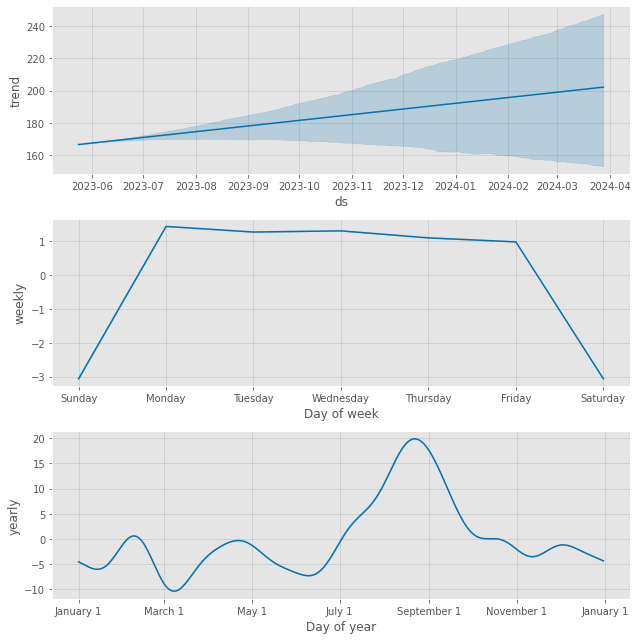

In [42]:
prophet.plot_components(test_predict)

In [43]:
prophet_data = df_prophet.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
prophet = Prophet()
prophet.fit(prophet_data)

23:14:43 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
future = prophet.make_future_dataframe(periods=num_days_pred, freq='d', include_history=False)
forecast = prophet.predict(future)
forecast_prophet = forecast[['ds','yhat']]
forecast_prophet.index = forecast_prophet.pop('ds')

In [46]:
# lets predict 'Close' values of next 30 days.
forecast_prophet

,yhat
ds,
2024-03-29,176.959889
2024-03-30,179.770239
2024-03-31,180.029791
2024-04-01,177.963160
2024-04-02,178.078893
2024-04-03,178.358776
2024-04-04,178.376854
2024-04-05,178.543855
2024-04-06,181.233551


# ARIMA

In [47]:
df_arima = stock_data.copy()

Spliting data

In [48]:
split_date = df_prophet.index[int(len(df_arima) * 0.8)]
train_arima = df_arima.loc[df_arima.index <= split_date].copy()
test_arima = df_arima.loc[df_arima.index > split_date].copy()

hyperparamter tuning

In [50]:
# Try to find the best parameters for arima model 
stepwise_fit = auto_arima(train_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4145.851, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4142.717, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4141.845, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4141.636, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4142.229, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4142.438, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4142.656, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4144.366, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4141.360, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4142.360, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4142.511, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4141.542, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4144.288, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.620 seconds


train

In [51]:
arima = ARIMA(train_arima['Close'], order=best_order)
arima = arima.fit()

evaluate

In [52]:
start = len(train_arima)
end = len(test_arima) + len(train_arima)

In [53]:
pred_arima = arima.predict(start=start,end=end-1)

In [54]:
pred_arima.index = test_arima.index

<AxesSubplot:xlabel='Date'>

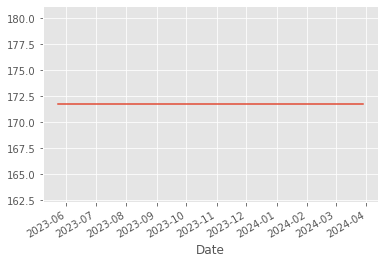

In [55]:
pred_arima.plot()

In [56]:
arima_loss = mean_absolute_percentage_error(test_arima['Close'],pred_arima )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test_arima['Close'],pred_arima ) }% ")

ERROR PERCENT = 6.236147789933887% 


predict into future

In [57]:
# Try to find the best parameters for arima model 
stepwise_fit = auto_arima(df_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

arima = ARIMA(df_arima['Close'], order=best_order)
arima = arima.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5085.850, Time=4.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5097.610, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5098.506, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5098.463, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5096.910, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5097.780, Time=1.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5101.912, Time=0.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5101.710, Time=4.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5102.074, Time=3.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5099.921, Time=0.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5099.724, Time=1.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5103.881, Time=1.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5104.580, Time=4.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5085.294, Time=1.95 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [58]:
start = len(df_arima)
end = len(df_arima) + num_days_pred
arima_forecast = arima.predict(start=start,end=end)

In [59]:
start = df_arima.index.max()
end = start + pd.Timedelta(days=num_days_pred)
arima_forecast.index = pd.date_range(start, end, freq='1d')

In [60]:
arima_forecast = pd.DataFrame(arima_forecast)

# Communicate the results

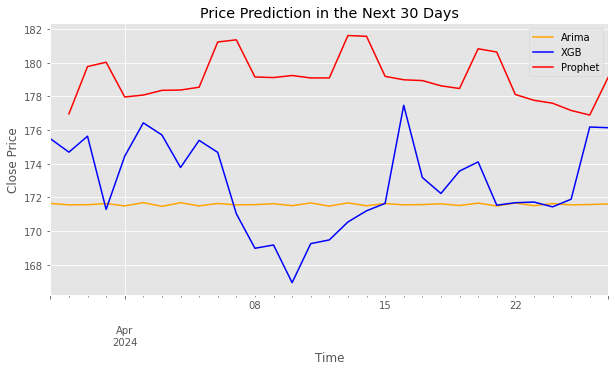

In [61]:
# compare results of ARIMA, XGB and Prophet
fig, ax  = plt.subplots(figsize=(10,5))
arima_forecast.plot(color='orange',ax=ax)
prediction_xgb.plot(color = 'blue',ax=ax)
forecast_prophet.plot(color = 'red',ax=ax)
plt.legend(['Arima','XGB','Prophet'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");

In [62]:
print(f"XGB Acc : {100-xgb_loss} \nArima Acc : {100-arima_loss}\nProphet Acc : {100- porphet_loss}")

XGB Acc : 98.2330417555254 
Arima Acc : 93.76385221006612
Prophet Acc : 93.56382410472162
